### Segmentation DRIVE and STARE Datesets

##### Import statements

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from sklearn.metrics import recall_score, f1_score
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import normalize
import albumentations

##### Defining Model

In [2]:
def create_model( img_size):
    inputs = keras.Input( shape=img_size + ( 3,))

    # Contraction Path
    c1 = keras.layers.Conv2D( 16, 3, activation="relu", kernel_initializer="he_normal", padding="same")( inputs)
    c1 = keras.layers.Dropout( 0.1)( c1)
    c1 = keras.layers.Conv2D( 16, 3, activation="relu", kernel_initializer="he_normal", padding="same")( c1)
    b1 = keras.layers.BatchNormalization()( c1)
    r1 = keras.layers.ReLU()( b1)
    p1 = keras.layers.MaxPooling2D( ( 2, 2))( r1)

    c2 = keras.layers.Conv2D( 32, 3, activation="relu", kernel_initializer="he_normal", padding="same")( p1)
    c2 = keras.layers.Dropout( 0.1)( c2)
    c2 = keras.layers.Conv2D( 32, 3, activation="relu", kernel_initializer="he_normal", padding="same")( c2)
    b2 = keras.layers.BatchNormalization()( c2)
    r2 = keras.layers.ReLU()( b2)
    p2 = keras.layers.MaxPooling2D( ( 2, 2))( r2)

    c3 = keras.layers.Conv2D( 64, 3, activation="relu", kernel_initializer="he_normal", padding="same")( p2)
    c3 = keras.layers.Dropout( 0.2)( c3)
    c3 = keras.layers.Conv2D(64, 3, activation="relu", kernel_initializer="he_normal", padding="same")( c3)
    b3 = keras.layers.BatchNormalization()( c3)
    r3 = keras.layers.ReLU()( b3)
    p3 = keras.layers.MaxPooling2D( ( 2, 2))( r3)

    c4 = keras.layers.Conv2D( 128, 3, activation="relu", kernel_initializer="he_normal", padding="same")( p3)
    c4 = keras.layers.Dropout( 0.2)( c4)
    c4 = keras.layers.Conv2D( 128, 3, activation="relu", kernel_initializer="he_normal", padding="same")( c4)
    b4 = keras.layers.BatchNormalization()( c4)
    r4 = keras.layers.ReLU()( b4)
    p4 = keras.layers.MaxPooling2D( ( 2, 2))( r4)

    c5 = keras.layers.Conv2D( 256, 3, activation="relu", kernel_initializer="he_normal", padding="same")( p4)
    b5 = keras.layers.BatchNormalization()( c5)
    r5 = keras.layers.ReLU()( b5)
    c5 = keras.layers.Dropout( 0.3)( r5)
    c5 = keras.layers.Conv2D( 256, 3, activation="relu", kernel_initializer="he_normal", padding="same")( c5)

    # Expansive Path
    u6 = keras.layers.Conv2DTranspose( 128, ( 2, 2), strides=( 2, 2), padding="same")( c5)
    u6 = keras.layers.concatenate( [ u6, c4])
    u6 = keras.layers.BatchNormalization()( u6)
    u6 = keras.layers.ReLU()( u6)

    u7 = keras.layers.Conv2DTranspose( 64, ( 2, 2), strides=( 2, 2), padding="same")( u6)
    u7 = keras.layers.concatenate( [ u7, c3])
    u7 = keras.layers.BatchNormalization()( u7)
    u7 = keras.layers.ReLU()( u7)

    u8 = keras.layers.Conv2DTranspose( 32, ( 2, 2), strides=( 2, 2), padding="same")( u7)
    u8 = keras.layers.concatenate( [ u8, c2])
    u8 = keras.layers.BatchNormalization()( u8)
    u8 = keras.layers.ReLU()( u8)

    u9 = keras.layers.Conv2DTranspose( 16, ( 2, 2), strides=( 2, 2), padding="same")( u8)
    u9 = keras.layers.concatenate( [ u9, c1], axis=3)
    u9 = keras.layers.BatchNormalization()( u9)
    u9 = keras.layers.ReLU()( u9)

    outputs = keras.layers.Conv2D( 1, 1, activation="sigmoid")( u9)

    model = keras.Model( inputs, outputs)

    return model

##### Sequence class to load & vectorize batches of data

In [3]:
image_mask_augmentation = albumentations.Compose( [
    albumentations.Flip(),
    albumentations.RandomRotate90(),
    albumentations.SafeRotate( limit=15, border_mode=0, value=0, mask_value=0),
    albumentations.Affine( scale=( 0.5, 0.9), keep_ratio=True)
])

image_augmentation = albumentations.Compose( [
    albumentations.RandomBrightnessContrast( brightness_limit=0.3, contrast_limit=0.3),
    albumentations.HueSaturationValue( hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5)
])

class Sequence( keras.utils.Sequence):
    # Helper to iterate over the data (as Numpy arrays)

    def __init__( self, batch_size, img_size, image_paths, mask_paths, augmentation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augmentation = augmentation

    def __len__( self):
        if len( self.mask_paths) < self.batch_size:
            return 1
        return len( self.mask_paths) // self.batch_size

    def __getitem__( self, idx):
        # Return tuple ( image, label) correspond to batch idx

        i = idx * self.batch_size

        batch_image_paths = self.image_paths[ i: i + self.batch_size]
        batch_mask_paths = self.mask_paths[ i: i + self.batch_size]

        x = np.zeros( ( self.batch_size,) + self.img_size + ( 3,), dtype="float32")
        y = np.zeros( ( self.batch_size,) + self.img_size + ( 1,), dtype="uint8")

        for j in range( self.batch_size):
            image = Image.open( batch_image_paths[ j % len( batch_image_paths)])
            image = np.array( image)

            mask = Image.open( batch_mask_paths[ j % len( batch_mask_paths)])
            mask = np.array( mask)
            mask = np.uint8( mask / 255)

            if self.augmentation == True:
                transform1 = image_mask_augmentation( image=image, mask=mask)
                transform2 = image_augmentation( image=transform1[ "image"])

                image = transform2[ "image"]
                mask = transform1[ "mask"]

            x[ j] = image
            y[ j] = np.expand_dims( mask, 2)

        seed = np.random.randint( 1, 1000)

        np.random.RandomState( seed).shuffle( x)
        np.random.RandomState( seed).shuffle( y)

        return x, y

##### Constants

In [4]:
IMG_SIZE = ( 256, 256)

##### DRIVE (Train & Test)

- List image and mask paths

In [5]:
image_dir_DRIVE = "Data-Sets/DRIVE/Images"
mask_dir_DRIVE = "Data-Sets/DRIVE/Labels"

image_paths_DRIVE = sorted(
    [
        os.path.join( image_dir_DRIVE, fname)
        for fname in os.listdir( image_dir_DRIVE)
        if fname.endswith( ".png")
    ]
)

mask_paths_DRIVE = sorted(
    [
        os.path.join( mask_dir_DRIVE, fname)
        for fname in os.listdir( mask_dir_DRIVE)
        if fname.endswith( ".png")
    ]
)

print( f"Number of Samples in DRIVE Dataset: { len( image_paths_DRIVE)}")

for image_path, mask_path in zip( image_paths_DRIVE, mask_paths_DRIVE):
    print( f"{ image_path} | { mask_path}")

Number of Samples in DRIVE Dataset: 20
Data-Sets/DRIVE/Images/00.png | Data-Sets/DRIVE/Labels/00.png
Data-Sets/DRIVE/Images/01.png | Data-Sets/DRIVE/Labels/01.png
Data-Sets/DRIVE/Images/02.png | Data-Sets/DRIVE/Labels/02.png
Data-Sets/DRIVE/Images/03.png | Data-Sets/DRIVE/Labels/03.png
Data-Sets/DRIVE/Images/04.png | Data-Sets/DRIVE/Labels/04.png
Data-Sets/DRIVE/Images/05.png | Data-Sets/DRIVE/Labels/05.png
Data-Sets/DRIVE/Images/06.png | Data-Sets/DRIVE/Labels/06.png
Data-Sets/DRIVE/Images/07.png | Data-Sets/DRIVE/Labels/07.png
Data-Sets/DRIVE/Images/08.png | Data-Sets/DRIVE/Labels/08.png
Data-Sets/DRIVE/Images/09.png | Data-Sets/DRIVE/Labels/09.png
Data-Sets/DRIVE/Images/10.png | Data-Sets/DRIVE/Labels/10.png
Data-Sets/DRIVE/Images/11.png | Data-Sets/DRIVE/Labels/11.png
Data-Sets/DRIVE/Images/12.png | Data-Sets/DRIVE/Labels/12.png
Data-Sets/DRIVE/Images/13.png | Data-Sets/DRIVE/Labels/13.png
Data-Sets/DRIVE/Images/14.png | Data-Sets/DRIVE/Labels/14.png
Data-Sets/DRIVE/Images/15.png |

- Split data into train, validation and test set

In [6]:
test_samples_n = int( 0.3 * len( image_paths_DRIVE))		#	30% for test set
validation_samples_n = int( 0.2 * len( image_paths_DRIVE))	#	20% for validation set

print( f"Number of Test Samples: { test_samples_n}")
print( f"Number of Validation Samples: { validation_samples_n}")
print( f"Number of Train Samples: { len( image_paths_DRIVE) - ( test_samples_n + validation_samples_n)}")

seed = 6347

random.Random( seed).shuffle( image_paths_DRIVE)
random.Random( seed).shuffle( mask_paths_DRIVE)

test_image_paths= image_paths_DRIVE[ 0: test_samples_n]
test_mask_paths = mask_paths_DRIVE[ 0: test_samples_n]

validation_image_paths = image_paths_DRIVE[ test_samples_n: test_samples_n + validation_samples_n]
validation_mask_paths = mask_paths_DRIVE[ test_samples_n: test_samples_n + validation_samples_n]

train_image_paths = image_paths_DRIVE[  test_samples_n + validation_samples_n:]
train_mask_paths = mask_paths_DRIVE[  test_samples_n + validation_samples_n:]

test_gen = Sequence( 1, IMG_SIZE, test_image_paths, test_mask_paths)
validation_gen = Sequence( 4, IMG_SIZE, validation_image_paths, validation_mask_paths)
train_gen = Sequence( 16, IMG_SIZE, train_image_paths, train_mask_paths, augmentation=True)

Number of Test Samples: 6
Number of Validation Samples: 4
Number of Train Samples: 10


- Compute class weight

In [7]:
class_weights = []

train_orig_gen = Sequence( 10, IMG_SIZE, train_image_paths, train_mask_paths)

_, y_train = train_orig_gen[ 0]

for idx, mask in enumerate( y_train):
    mask_ravel = np.ravel( mask)

    neg = np.count_nonzero( mask_ravel < 1)
    pos = np.count_nonzero( mask_ravel > 0)
    n = pos + neg

    neg_w = neg / n
    pos_w = pos / n

    class_weight = [ 1 / neg_w, 1 / pos_w]

    class_weights.append( class_weight)

    print( f"#{ idx:02d} - 1s: { pos_w:.2f}, 0s: { neg_w:.2f} - Class Weight: { class_weight}")

class_weights = np.mean( class_weights, axis=0)

print( f"Mean Class Weight: { class_weights}")

#00 - 1s: 0.12, 0s: 0.88 - Class Weight: [1.1365938258758237, 8.320975114271203]
#01 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.2024071627770438, 5.940536620739667]
#02 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.2078364879559151, 5.811474682983063]
#03 - 1s: 0.20, 0s: 0.80 - Class Weight: [1.2575748853453073, 4.882366088057811]
#04 - 1s: 0.19, 0s: 0.81 - Class Weight: [1.2274727950403626, 5.396130094689172]
#05 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.2050603118564283, 5.87661406025825]
#06 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.2036880578922236, 5.909467989179441]
#07 - 1s: 0.15, 0s: 0.85 - Class Weight: [1.1820001803589142, 6.494500049549103]
#08 - 1s: 0.16, 0s: 0.84 - Class Weight: [1.1917369799243527, 6.215477996965099]
#09 - 1s: 0.15, 0s: 0.85 - Class Weight: [1.1806161052062691, 6.536604827448634]
Mean Class Weight: [1.19949868 6.13841475]


- Showing three samples of training set

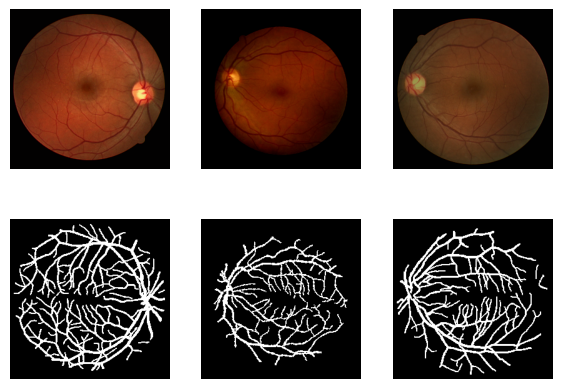

In [8]:
x, y = train_gen[ 0]

fig = plt.figure( figsize=( 7, 5))

for i in range( 3):
    fig.add_subplot( 2, 3, i + 1)
    plt.axis( "off")
    plt.imshow( np.uint8( x[ i]))

    fig.add_subplot( 2, 3, i + 4)
    plt.axis( "off")
    plt.imshow( np.uint8( y[ i]), cmap="gray")

plt.show()

- Instantiate the model

In [9]:
model = create_model( IMG_SIZE)

# keras.utils.plot_model( model)
# model.summary()

##### Callbacks

In [10]:
tensorboard_cb = keras.callbacks.TensorBoard()
early_stopping_cb = keras.callbacks.EarlyStopping( patience=200, restore_best_weights=True)

callbacks = [
	tensorboard_cb,
	early_stopping_cb
]

##### Define Weighte Binary Cross Entropy

In [11]:
def weighted_loss( lossFunc, weightsList):
	def loss_func( true, pred):
		class_selectors = true[:,:,:, 0]

		class_selectors = [ keras.backend.equal( np.uint8( i), class_selectors) for i in range( len( class_weights))]

		class_selectors = [ keras.backend.cast( x, keras.backend.floatx()) for x in class_selectors]

		weights = [ sel * w for sel, w in zip( class_selectors, class_weights)]

		weightMultiplier = keras.backend.sum( weights, axis=0)

		loss = keras.losses.binary_crossentropy( true, pred)
		loss = loss * weightMultiplier

		return loss
	return loss_func

- Train the model

In [12]:
model.compile(
    optimizer="adam",
    loss=weighted_loss( keras.losses.binary_crossentropy, class_weights),
		metrics=[ "accuracy"]
)

history = model.fit(
	train_gen,
	validation_data=validation_gen,
	epochs=2000,
	callbacks=[ callbacks],
	verbose=0
)

- Plot train curve

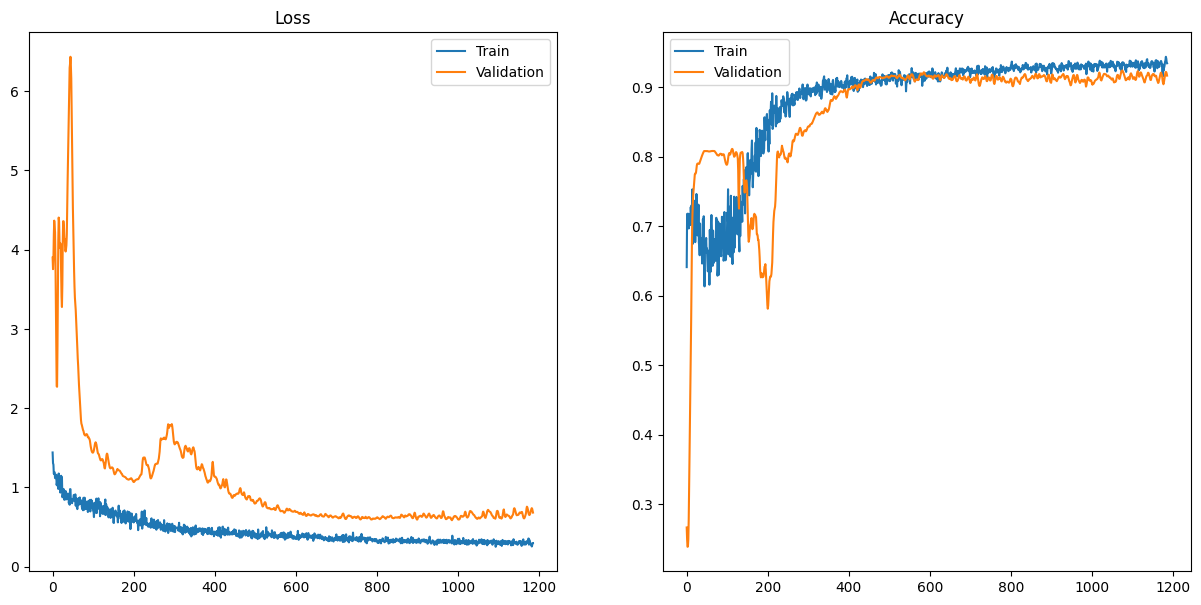

In [13]:
train_loss = history.history[ "loss"]
train_accuracy = history.history[ "accuracy"]

validation_loss = history.history[ "val_loss"]
validation_accuracy = history.history[ "val_accuracy"]

fig = plt.figure( figsize=( 15, 7))

fig.add_subplot( 1, 2, 1)
plt.plot( train_loss, label="Train")
plt.plot( validation_loss, label="Validation")
plt.title( "Loss")
plt.legend()

fig.add_subplot( 1, 2, 2)
plt.plot( train_accuracy, label="Train")
plt.plot( validation_accuracy, label="Validation")
plt.title( "Accuracy")
plt.legend()

plt.show()

- Accuracy

In [14]:
evaluation_loss, evaluation_accuracy = model.evaluate( test_gen)

print( f"Evaluation Loss: { evaluation_loss}")
print( f"Evaluation Accuracy: { evaluation_accuracy}")

6/6 [==============================] - 1s 8ms/step - loss: 0.5897 - accuracy: 0.8862
Evaluation Loss: 0.5897251963615417
Evaluation Accuracy: 0.8862202763557434


- Sensitivity and F1-score

In [15]:
test_preds = model.predict( test_gen)

sensitivities = []
f1s = []
for i in range( len( test_preds)):
	y_true = np.ravel( test_gen[ i][ 1])
	y_pred = np.ravel( test_preds[ i].round())

	sensitivities.append( recall_score( y_true, y_pred))
	f1s.append( f1_score( y_true, y_pred))

print( f"Sensitivity: { np.mean( sensitivities)}")
print( f"F1-score: { np.mean( f1s)}")

6/6 [==============================] - 0s 7ms/step
Sensitivity: 0.875273986146591
F1-score: 0.7203592523215483


- Visualizing output

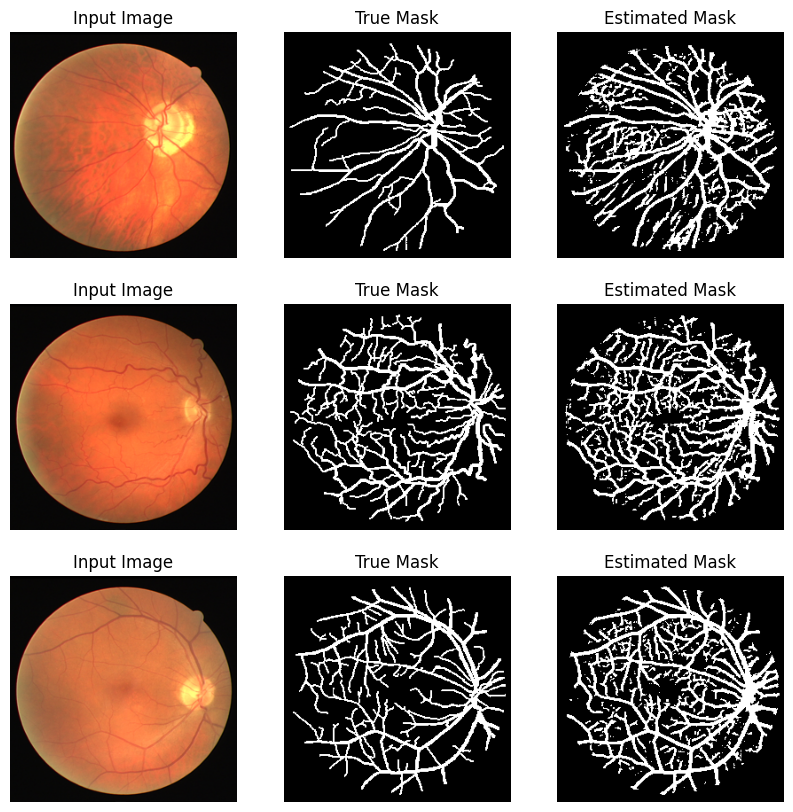

In [16]:
fig = plt.figure( figsize=( 10, 10))

for i in range( 3):
    x, y = test_gen[ i]
    mask = test_preds[ i].round()

    fig.add_subplot( 3, 3, i * 3 + 1)
    plt.imshow( np.uint8( x[ 0]))
    plt.title( "Input Image")
    plt.axis( "off")

    fig.add_subplot( 3, 3, i * 3 + 2)
    plt.imshow( np.uint8( y[ 0]), cmap="gray")
    plt.title( "True Mask")
    plt.axis( "off")

    fig.add_subplot( 3, 3, i * 3 + 3)
    plt.imshow( mask, cmap="gray")
    plt.title( "Estimated Mask")
    plt.axis( "off")

plt.show()

##### STARE (Train & Test)

- List images and mask paths

In [17]:
image_dir_STARE = "Data-Sets/STARE/Images"
mask_dir_STARE = "Data-Sets/STARE/Labels"

image_paths_STARE = sorted(
    [
        os.path.join( image_dir_STARE, fname)
        for fname in os.listdir( image_dir_STARE)
        if fname.endswith( ".png")
    ]
)

mask_paths_STARE = sorted(
    [
        os.path.join( mask_dir_STARE, fname)
        for fname in os.listdir( mask_dir_STARE)
        if fname.endswith( ".png")
    ]
)

print( f"Number of Samples in STARE Dataset: { len( image_paths_STARE)}")

for image_path, mask_path in zip( image_paths_STARE, mask_paths_STARE):
    print( f"{ image_path} | { mask_path}")

Number of Samples in STARE Dataset: 20
Data-Sets/STARE/Images/00.png | Data-Sets/STARE/Labels/00.png
Data-Sets/STARE/Images/01.png | Data-Sets/STARE/Labels/01.png
Data-Sets/STARE/Images/02.png | Data-Sets/STARE/Labels/02.png
Data-Sets/STARE/Images/03.png | Data-Sets/STARE/Labels/03.png
Data-Sets/STARE/Images/04.png | Data-Sets/STARE/Labels/04.png
Data-Sets/STARE/Images/05.png | Data-Sets/STARE/Labels/05.png
Data-Sets/STARE/Images/06.png | Data-Sets/STARE/Labels/06.png
Data-Sets/STARE/Images/07.png | Data-Sets/STARE/Labels/07.png
Data-Sets/STARE/Images/08.png | Data-Sets/STARE/Labels/08.png
Data-Sets/STARE/Images/09.png | Data-Sets/STARE/Labels/09.png
Data-Sets/STARE/Images/10.png | Data-Sets/STARE/Labels/10.png
Data-Sets/STARE/Images/11.png | Data-Sets/STARE/Labels/11.png
Data-Sets/STARE/Images/12.png | Data-Sets/STARE/Labels/12.png
Data-Sets/STARE/Images/13.png | Data-Sets/STARE/Labels/13.png
Data-Sets/STARE/Images/14.png | Data-Sets/STARE/Labels/14.png
Data-Sets/STARE/Images/15.png |

- Split data into train, validation and test set

In [18]:
test_samples_n = int( 0.3 * len( image_paths_STARE))		#	30% for test set
validation_samples_n = int( 0.2 * len( image_paths_STARE))	#	20% for validation set

print( f"Number of Test Samples: { test_samples_n}")
print( f"Number of Validation Samples: { validation_samples_n}")
print( f"Number of Train Samples: { len( image_paths_STARE) - ( test_samples_n + validation_samples_n)}")

seed = 1987

random.Random( seed).shuffle( image_paths_STARE)
random.Random( seed).shuffle( mask_paths_STARE)

test_image_paths= image_paths_STARE[ 0: test_samples_n]
test_mask_paths = mask_paths_STARE[ 0: test_samples_n]

validation_image_paths = image_paths_STARE[ test_samples_n: test_samples_n + validation_samples_n]
validation_mask_paths = mask_paths_STARE[ test_samples_n: test_samples_n + validation_samples_n]

train_image_paths = image_paths_STARE[  test_samples_n + validation_samples_n:]
train_mask_paths = mask_paths_STARE[  test_samples_n + validation_samples_n:]

test_gen = Sequence( 1, IMG_SIZE, test_image_paths, test_mask_paths)
validation_gen = Sequence( 4, IMG_SIZE, validation_image_paths, validation_mask_paths)
train_gen = Sequence( 16, IMG_SIZE, train_image_paths, train_mask_paths, augmentation=True)

Number of Test Samples: 6
Number of Validation Samples: 4
Number of Train Samples: 10


- Compute class weight

In [19]:
class_weights = []

train_orig_gen = Sequence( 10, IMG_SIZE, train_image_paths, train_mask_paths)

_, y_train = train_orig_gen[ 0]

for idx, mask in enumerate( y_train):
    mask_ravel = np.ravel( mask)

    neg = np.count_nonzero( mask_ravel < 1)
    pos = np.count_nonzero( mask_ravel > 0)
    n = pos + neg

    neg_w = neg / n
    pos_w = pos / n

    class_weight = [ 1 / neg_w, 1 / pos_w]

    class_weights.append( class_weight)

    print( f"#{ idx:02d} - 1s: { pos_w:.2f}, 0s: { neg_w:.2f} - Class Weight: { class_weight}")

class_weights = np.mean( class_weights, axis=0)

print( f"Mean Class Weight: { class_weights}")

#00 - 1s: 0.09, 0s: 0.91 - Class Weight: [1.0965248381213712, 11.360027734442712]
#01 - 1s: 0.14, 0s: 0.86 - Class Weight: [1.1617798262719377, 7.181240412009643]
#02 - 1s: 0.18, 0s: 0.82 - Class Weight: [1.2237824917836868, 5.468624833110814]
#03 - 1s: 0.16, 0s: 0.84 - Class Weight: [1.1864296317752272, 6.363954165857448]
#04 - 1s: 0.21, 0s: 0.79 - Class Weight: [1.2685778440216025, 4.723315315315316]
#05 - 1s: 0.20, 0s: 0.80 - Class Weight: [1.2506870229007634, 4.989037758830694]
#06 - 1s: 0.20, 0s: 0.80 - Class Weight: [1.2553105905338364, 4.916797959336784]
#07 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.2026940228661613, 5.9335445903123585]
#08 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.211677482574371, 5.72416804961132]
#09 - 1s: 0.19, 0s: 0.81 - Class Weight: [1.2306305629624066, 5.335938772186941]
Mean Class Weight: [1.20880943 6.19966496]


- Showing three samples of training set

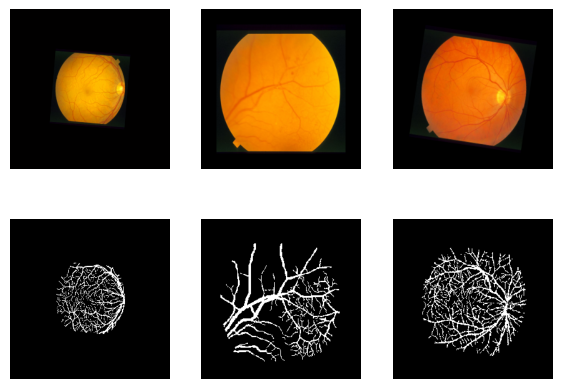

In [20]:
x, y = train_gen[ 0]

fig = plt.figure( figsize=( 7, 5))

for i in range( 3):
    fig.add_subplot( 2, 3, i + 1)
    plt.axis( "off")
    plt.imshow( np.uint8( x[ i]))

    fig.add_subplot( 2, 3, i + 4)
    plt.axis( "off")
    plt.imshow( np.uint8( y[ i]), cmap="gray")

plt.show()

- Instantiate the model

In [21]:
keras.backend.clear_session()

model = create_model( IMG_SIZE)

- Train the model

In [22]:
model.compile(
	optimizer="adam",
	loss=weighted_loss( keras.losses.binary_crossentropy, class_weights),
	metrics=[ "accuracy"]
)

history = model.fit(
	train_gen,
	validation_data=validation_gen,
	epochs=2000,
	callbacks=[ callbacks],
	verbose=0
)

- Plot train curve

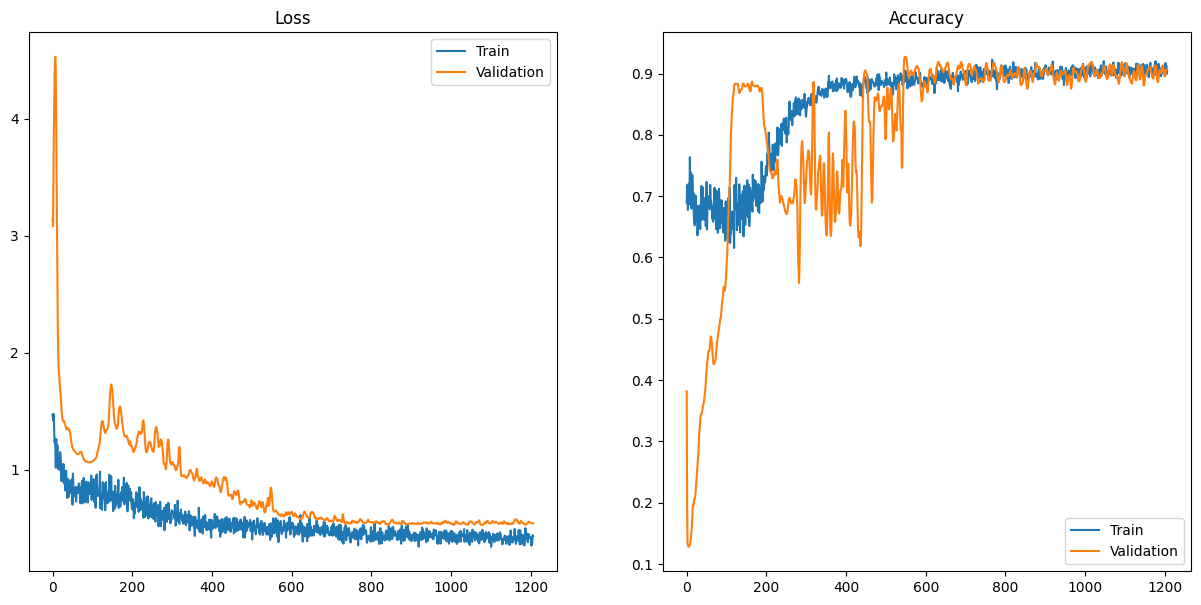

In [23]:
train_loss = history.history[ "loss"]
train_accuracy = history.history[ "accuracy"]

validation_loss = history.history[ "val_loss"]
validation_accuracy = history.history[ "val_accuracy"]

fig = plt.figure( figsize=( 15, 7))

fig.add_subplot( 1, 2, 1)
plt.plot( train_loss, label="Train")
plt.plot( validation_loss, label="Validation")
plt.title( "Loss")
plt.legend()

fig.add_subplot( 1, 2, 2)
plt.plot( train_accuracy, label="Train")
plt.plot( validation_accuracy, label="Validation")
plt.title( "Accuracy")
plt.legend()

plt.show()

- Accuracy

In [24]:
evaluation_loss, evaluation_accuracy = model.evaluate( test_gen)

print( f"Evaluation Loss: { evaluation_loss}")
print( f"Evaluation Accuracy: { evaluation_accuracy}")

6/6 [==============================] - 0s 15ms/step - loss: 0.5634 - accuracy: 0.8927
Evaluation Loss: 0.563442051410675
Evaluation Accuracy: 0.8927383422851562


- Sensitivity and F1-score

In [25]:
test_preds = model.predict( test_gen)

sensitivities = []
f1s = []
for i in range( len( test_preds)):
	y_true = np.ravel( test_gen[ i][ 1])
	y_pred = np.ravel( test_preds[ i].round())

	sensitivities.append( recall_score( y_true, y_pred))
	f1s.append( f1_score( y_true, y_pred))

print( f"Sensitivity: { np.mean( sensitivities)}")
print( f"F1-score: { np.mean( f1s)}")

6/6 [==============================] - 0s 7ms/step
Sensitivity: 0.8522688554598014
F1-score: 0.7088907016121931


- Visualizing output

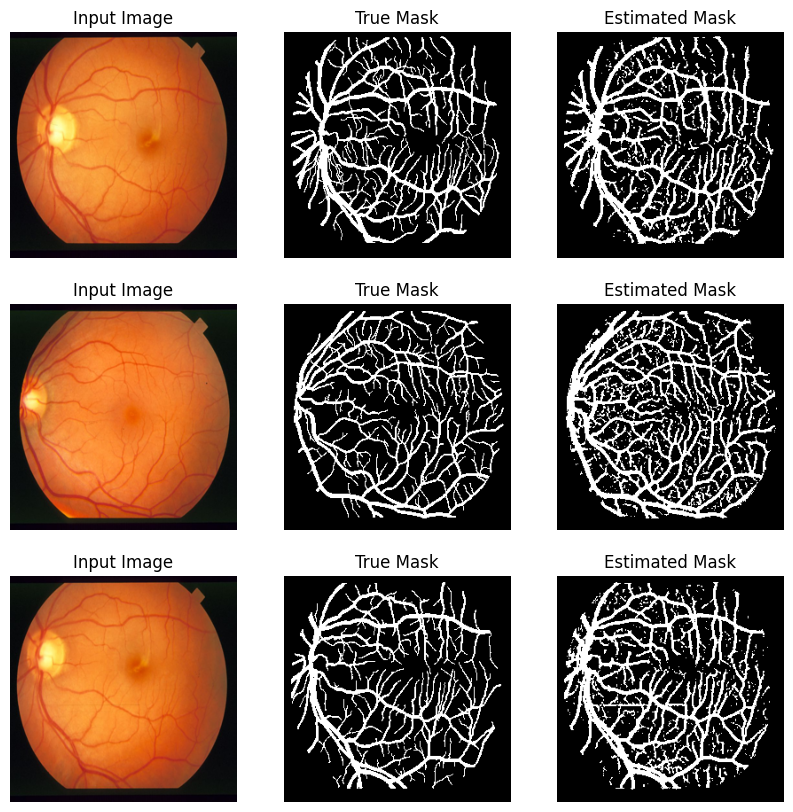

In [26]:
fig = plt.figure( figsize=( 10, 10))

for i in range( 3):
    x, y = test_gen[ i]
    mask = test_preds[ i].round()

    fig.add_subplot( 3, 3, i * 3 + 1)
    plt.imshow( np.uint8( x[ 0]))
    plt.title( "Input Image")
    plt.axis( "off")

    fig.add_subplot( 3, 3, i * 3 + 2)
    plt.imshow( np.uint8( y[ 0]), cmap="gray")
    plt.title( "True Mask")
    plt.axis( "off")

    fig.add_subplot( 3, 3, i * 3 + 3)
    plt.imshow( mask, cmap="gray")
    plt.title( "Estimated Mask")
    plt.axis( "off")

plt.show()

##### STARE (Train), DRIVE (Test)

- List images and mask paths

In [27]:
print( f"Number of Samples in Both Dataset: { len( image_paths_DRIVE) + len( image_paths_STARE)}")

for image_path, mask_path in zip( image_paths_DRIVE, mask_paths_DRIVE):
    print( f"{ image_path} | { mask_path}")

for image_path, mask_path in zip( image_paths_STARE, mask_paths_STARE):
    print( f"{ image_path} | { mask_path}")

Number of Samples in Both Dataset: 40
Data-Sets/DRIVE/Images/10.png | Data-Sets/DRIVE/Labels/10.png
Data-Sets/DRIVE/Images/01.png | Data-Sets/DRIVE/Labels/01.png
Data-Sets/DRIVE/Images/12.png | Data-Sets/DRIVE/Labels/12.png
Data-Sets/DRIVE/Images/13.png | Data-Sets/DRIVE/Labels/13.png
Data-Sets/DRIVE/Images/08.png | Data-Sets/DRIVE/Labels/08.png
Data-Sets/DRIVE/Images/14.png | Data-Sets/DRIVE/Labels/14.png
Data-Sets/DRIVE/Images/07.png | Data-Sets/DRIVE/Labels/07.png
Data-Sets/DRIVE/Images/03.png | Data-Sets/DRIVE/Labels/03.png
Data-Sets/DRIVE/Images/04.png | Data-Sets/DRIVE/Labels/04.png
Data-Sets/DRIVE/Images/09.png | Data-Sets/DRIVE/Labels/09.png
Data-Sets/DRIVE/Images/15.png | Data-Sets/DRIVE/Labels/15.png
Data-Sets/DRIVE/Images/02.png | Data-Sets/DRIVE/Labels/02.png
Data-Sets/DRIVE/Images/17.png | Data-Sets/DRIVE/Labels/17.png
Data-Sets/DRIVE/Images/05.png | Data-Sets/DRIVE/Labels/05.png
Data-Sets/DRIVE/Images/06.png | Data-Sets/DRIVE/Labels/06.png
Data-Sets/DRIVE/Images/11.png | 

- Split data into train, validation and test set

In [28]:
validation_samples_n = int( 0.3 * len( image_paths_STARE))

print( f"Number of Test Samples: { len( image_paths_DRIVE)}")
print( f"Number of Validation Samples: { validation_samples_n}")
print( f"Number of Train Samples: { len( image_paths_STARE) - validation_samples_n}")

seed = 8913

random.Random( seed).shuffle( image_paths_STARE)
random.Random( seed).shuffle( mask_paths_STARE)

test_image_paths = image_paths_DRIVE
test_mask_paths = mask_paths_DRIVE

validation_image_paths = image_paths_STARE[ : validation_samples_n]
validation_mask_paths = mask_paths_STARE[ : validation_samples_n]

train_image_paths = image_paths_STARE[ validation_samples_n:]
train_mask_paths = mask_paths_STARE[ validation_samples_n:]

test_gen = Sequence( 1, IMG_SIZE, test_image_paths, test_mask_paths)
validation_gen = Sequence( 6, IMG_SIZE, validation_image_paths, validation_mask_paths)
train_gen = Sequence( 16, IMG_SIZE, train_image_paths, train_mask_paths, augmentation=True)

Number of Test Samples: 20
Number of Validation Samples: 6
Number of Train Samples: 14


- Compute class weight

In [29]:
class_weights = []

train_orig_gen = Sequence( 10, IMG_SIZE, train_image_paths, train_mask_paths)

_, y_train = train_orig_gen[ 0]

for idx, mask in enumerate( y_train):
    mask_ravel = np.ravel( mask)

    neg = np.count_nonzero( mask_ravel < 1)
    pos = np.count_nonzero( mask_ravel > 0)
    n = pos + neg

    neg_w = neg / n
    pos_w = pos / n

    class_weight = [ 1 / neg_w, 1 / pos_w]

    class_weights.append( class_weight)

    print( f"#{ idx:02d} - 1s: { pos_w:.2f}, 0s: { neg_w:.2f} - Class Weight: { class_weight}")

class_weights = np.mean( class_weights, axis=0)

print( f"Mean Class Weight: { class_weights}")

#00 - 1s: 0.11, 0s: 0.89 - Class Weight: [1.1194697823784634, 9.370317414927081]
#01 - 1s: 0.19, 0s: 0.81 - Class Weight: [1.229476211916554, 5.3577501635055595]
#02 - 1s: 0.16, 0s: 0.84 - Class Weight: [1.1913037155529702, 6.227290003800836]
#03 - 1s: 0.13, 0s: 0.87 - Class Weight: [1.1544328770984165, 7.475305121478271]
#04 - 1s: 0.21, 0s: 0.79 - Class Weight: [1.2685778440216025, 4.723315315315316]
#05 - 1s: 0.17, 0s: 0.83 - Class Weight: [1.211677482574371, 5.72416804961132]
#06 - 1s: 0.10, 0s: 0.90 - Class Weight: [1.1083563057044767, 10.228812236616202]
#07 - 1s: 0.09, 0s: 0.91 - Class Weight: [1.0965248381213712, 11.360027734442712]
#08 - 1s: 0.09, 0s: 0.91 - Class Weight: [1.1021863437605113, 10.78604344963792]
#09 - 1s: 0.18, 0s: 0.82 - Class Weight: [1.2247201509969912, 5.44997920997921]
Mean Class Weight: [1.17067256 7.67030087]


- Showing three samples of training set

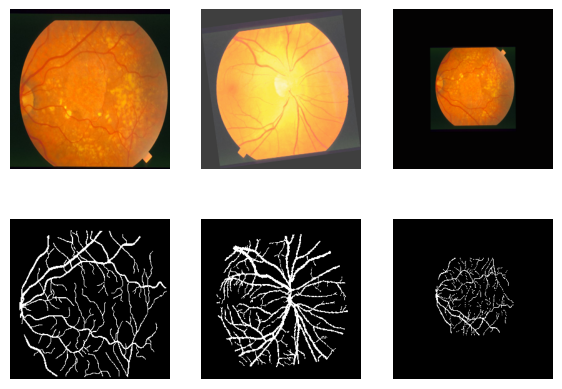

In [30]:
x, y = train_gen[ 0]

fig = plt.figure( figsize=( 7, 5))

for i in range( 3):
    fig.add_subplot( 2, 3, i + 1)
    plt.axis( "off")
    plt.imshow( np.uint8( x[ i]))

    fig.add_subplot( 2, 3, i + 4)
    plt.axis( "off")
    plt.imshow( np.uint8( y[ i]), cmap="gray")

plt.show()

- Instantiate the model

In [31]:
keras.backend.clear_session()

model = create_model( IMG_SIZE)

- Train the model

In [32]:
model.compile(
	optimizer="adam",
	loss=weighted_loss( keras.losses.binary_crossentropy, class_weights),
	metrics=[ "accuracy"]
)

history = model.fit(
	train_gen,
	validation_data=validation_gen,
	epochs=2000,
	callbacks=[ callbacks],
	verbose=0
)

- Plot train curve

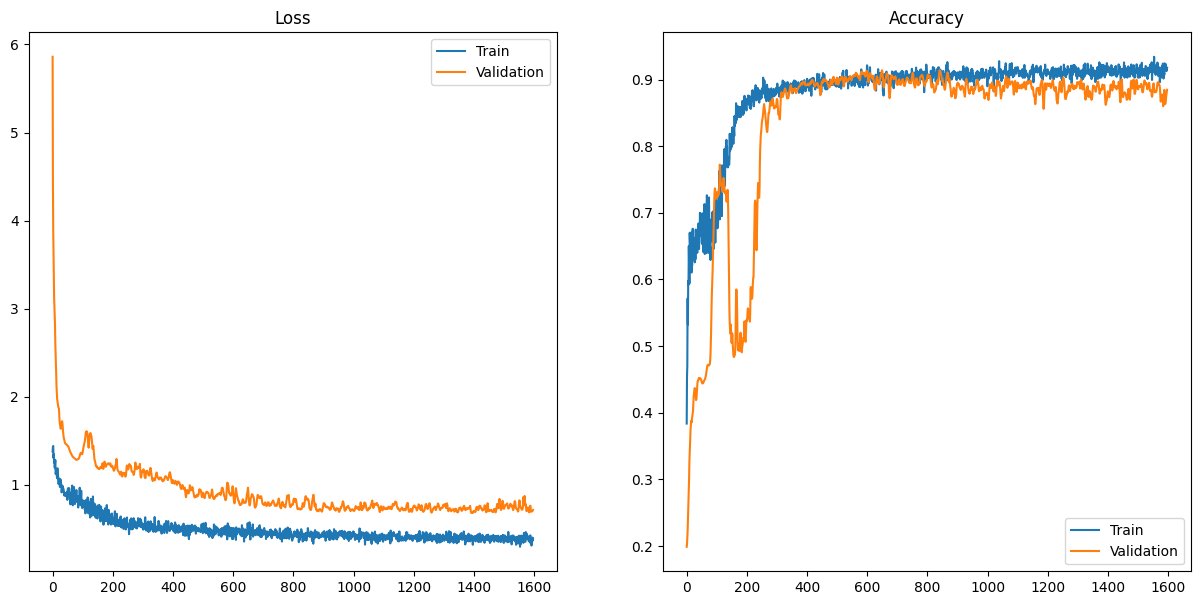

In [33]:
train_loss = history.history[ "loss"]
train_accuracy = history.history[ "accuracy"]

validation_loss = history.history[ "val_loss"]
validation_accuracy = history.history[ "val_accuracy"]

fig = plt.figure( figsize=( 15, 7))

fig.add_subplot( 1, 2, 1)
plt.plot( train_loss, label="Train")
plt.plot( validation_loss, label="Validation")
plt.title( "Loss")
plt.legend()

fig.add_subplot( 1, 2, 2)
plt.plot( train_accuracy, label="Train")
plt.plot( validation_accuracy, label="Validation")
plt.title( "Accuracy")
plt.legend()

plt.show()

- Accuracy

In [34]:
evaluation_loss, evaluation_accuracy = model.evaluate( test_gen)

print( f"Evaluation Loss: { evaluation_loss}")
print( f"Evaluation Accuracy: { evaluation_accuracy}")

20/20 [==============================] - 0s 8ms/step - loss: 0.6518 - accuracy: 0.8680
Evaluation Loss: 0.6517901420593262
Evaluation Accuracy: 0.8679977655410767


- Sensitivity and F1-score

In [35]:
test_preds = model.predict( test_gen)

sensitivities = []
f1s = []
for i in range( len( test_preds)):
	y_true = np.ravel( test_gen[ i][ 1])
	y_pred = np.ravel( test_preds[ i].round())

	sensitivities.append( recall_score( y_true, y_pred))
	f1s.append( f1_score( y_true, y_pred))

print( f"Sensitivity: { np.mean( sensitivities)}")
print( f"F1-score: { np.mean( f1s)}")

20/20 [==============================] - 0s 7ms/step
Sensitivity: 0.8753992994545658
F1-score: 0.693775723694187


- Visualizing output

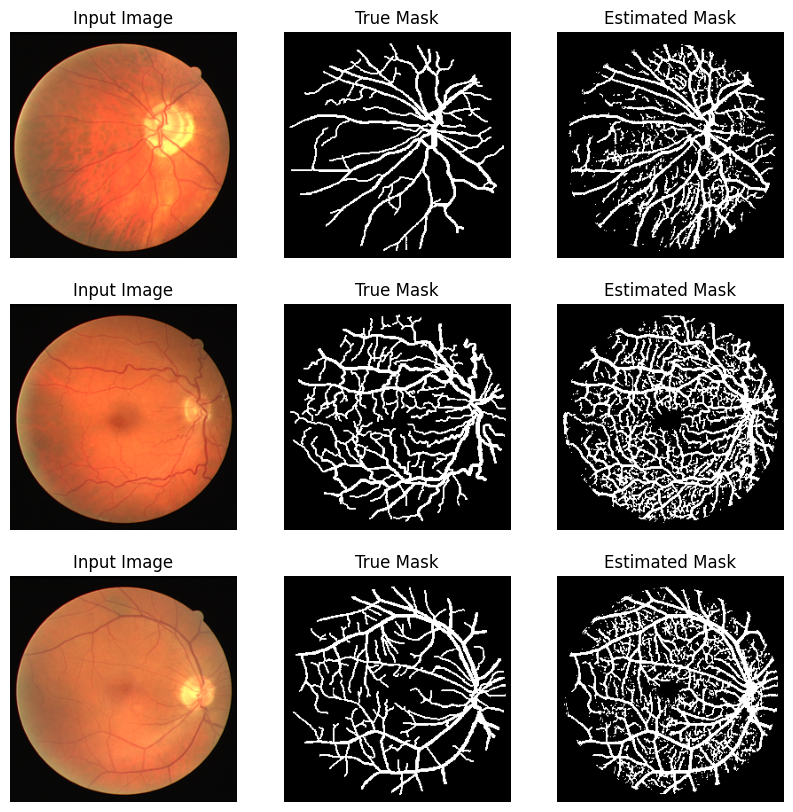

In [36]:
fig = plt.figure( figsize=( 10, 10))

for i in range( 3):
    x, y = test_gen[ i]
    mask = test_preds[ i].round()

    fig.add_subplot( 3, 3, i * 3 + 1)
    plt.imshow( np.uint8( x[ 0]))
    plt.title( "Input Image")
    plt.axis( "off")

    fig.add_subplot( 3, 3, i * 3 + 2)
    plt.imshow( np.uint8( y[ 0]), cmap="gray")
    plt.title( "True Mask")
    plt.axis( "off")

    fig.add_subplot( 3, 3, i * 3 + 3)
    plt.imshow( mask, cmap="gray")
    plt.title( "Estimated Mask")
    plt.axis( "off")

plt.show()